In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap
from sklearn.externals import joblib
from datetime import timedelta

# Optimisation

In [2]:
xls = pd.ExcelFile('deliveries.xlsx')

In [3]:
deliveries = pd.read_excel(xls, '2_months_deliverys_2013', usecols='A:D, F:H, J,K,L,O')

In [4]:
deliveries.dropna(inplace=True)

In [5]:
strip_cols = [x.strip() for x in deliveries.columns]
deliveries.columns = strip_cols 

In [6]:
deliveries.rename(columns={'Container type and size':'ContainerTypeSize', 'Time':'TimeStamp'}, inplace=True)

In [7]:
dates = pd.date_range(deliveries['TimeStamp'].dt.date.min(), deliveries['TimeStamp'].dt.date.max())

In [8]:
port_w_loc = deliveries[['Port','Port_Long', 'Port_Lat']]

In [9]:
unique_ports = port_w_loc.drop_duplicates(subset=['Port'])

In [10]:
unique_ports['Port'] = unique_ports['Port'].apply(lambda x: x.strip()) 

In [11]:
unique_ports = unique_ports.drop_duplicates(subset=['Port'])

In [12]:
unique_ports['Limits']= 0

In [13]:
unique_ports = unique_ports[['Port', 'Port_Lat', 'Port_Long', 'Limits']]

In [14]:
col_names = ['Port','Lat', 'Long', 'Limits']
unique_ports.columns = col_names

In [15]:
unique_ports.head()

,Port,Lat,Long,Limits
0,Felixstowe,51.9591,1.3141,0
1,Southampton,50.9028,-1.4150,0
3,Liverpool,53.4663,-3.0194,0
5,Grangemouth,56.0241,-3.7046,0
45,Selby,53.7855,-1.0556,0


## Depots

In [16]:
csv_depots = pd.read_csv('depots.csv')

In [17]:
csv_depots.dropna(inplace=True)

In [18]:
csv_depots.rename(columns={'long':'Lat', 'lat':'Long'}, inplace=True)

In [19]:
depots_w_loc = csv_depots[['Depot', 'Lat', 'Long']]

In [20]:
depots_w_loc['Depot'] = depots_w_loc['Depot'].apply(lambda x:x.strip())

In [21]:
depots_w_loc = depots_w_loc.drop_duplicates(subset=['Depot'])
depots_w_loc = depots_w_loc[['Depot','Long', 'Lat']]

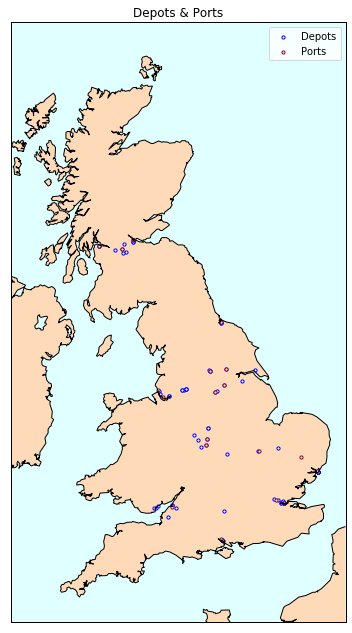

In [23]:
fig = plt.figure(figsize=(6,12))
m = Basemap(llcrnrlon=-7, llcrnrlat=49.5, urcrnrlon=3.5, urcrnrlat=59.5, resolution='i', projection='cass', lon_0=-4.36, lat_0=54.7)
m.scatter(depots_w_loc['Long'].tolist(), depots_w_loc['Lat'].tolist(), latlon=True, s=10, zorder=2, marker='o', color='white', edgecolor='blue', label='Depots')
m.scatter(unique_ports['Long'].tolist(), unique_ports['Lat'].tolist(), latlon=True, s=10, zorder=2, marker='o', color='yellow', edgecolor='purple', label='Ports')
m.drawcoastlines()
m.fillcontinents(color='peachpuff',lake_color='lightcyan', zorder=1)
m.drawmapboundary(fill_color='lightcyan')
plt.savefig('depot_locations', bbox_inches='tight')
plt.savefig('depot_locations', bbox_inches='tight')
plt.legend()
plt.title("Depots & Ports")
plt.savefig('depot_port_locations', bbox_inches='tight')
plt.show()

In [24]:
depots_w_loc['Depot'].count()+unique_ports['Port'].count()

95

In [25]:
csv_depots.shape

(79, 8)

## TEU Limits

In [26]:
teu_limits = pd.read_excel('TEU Limits.xlsx', usecols='A,B,D,G')
# read_excel('tmp.xlsx', index_col=0) 

In [27]:
# np.where(teu_limits['TEU Limit'] != np.nan
teu_limits['Limits'] = np.where(teu_limits['TEU Limit'].isnull(),teu_limits['Storage Limit'],teu_limits['TEU Limit'])

In [28]:
teu_limits = teu_limits[['Location Name', 'Location Name:Depot ID', 'Limits']]

In [29]:
# teu_limits = teu_limits.rename(columns={'Depot_ID': 'Code'})

In [30]:
teu_limits.head()

,Location Name,Location Name:Depot ID,Limits
0,A&D Logistics,9106,600.0
1,ACS - MSC Depot,8987,2000.0
2,Bristol Quay,9028,5000.0
3,Cleveland Containers,9004,3000.0
4,DP World London Gateway,9097,3500.0


In [31]:
csv_depots.head()

,Depot,Code,Lat,Long,address,city,area,PostCode
1,GB Railfreight,9005,53.525700,-1.134000,C/O Tibbett & Britten Doncaster International ...,Doncaster,Doncaster,DN4 5PD
4,John Joy Welding,9041,51.479000,0.294200,Europa Trading Centre London Road,Grays,Thurrock,RM20 4DB
6,Countrywide Freight Limited,9045,51.481756,0.308941,Askew Farm Road,Grays,Thurrock,RM17 5XR
7,F/L Cleveland,8990,54.583800,-1.134300,Trunk Road Grangetown,Middlesbrough,Middlesbrough,TS6 7SDF
8,Cleveland Containers,9004,54.579600,-1.159400,Cleveland House Grangetown,Middlesbrough,Middlesbrough,TS6 6UA


In [32]:
depot_w_limits = pd.merge(csv_depots, teu_limits, how='left', left_on='Code', right_on='Location Name:Depot ID')

In [33]:
depot_w_limits['Limits'] = depot_w_limits['Limits'].fillna(0) 

In [34]:
depot_w_limits_loc = depot_w_limits[['Depot', 'Lat', 'Long', 'Limits']]
depot_w_limits_loc.head()

,Depot,Lat,Long,Limits
0,GB Railfreight,53.525700,-1.134000,0.0
1,John Joy Welding,51.479000,0.294200,0.0
2,Countrywide Freight Limited,51.481756,0.308941,0.0
3,F/L Cleveland,54.583800,-1.134300,0.0
4,Cleveland Containers,54.579600,-1.159400,3000.0


In [35]:
unique_ports.head()

,Port,Lat,Long,Limits
0,Felixstowe,51.9591,1.3141,0
1,Southampton,50.9028,-1.4150,0
3,Liverpool,53.4663,-3.0194,0
5,Grangemouth,56.0241,-3.7046,0
45,Selby,53.7855,-1.0556,0


In [36]:
ports_depots = pd.DataFrame(np.concatenate((depot_w_limits_loc.values, unique_ports.values), axis=0))
ports_depots.columns = ['Port_Depot', 'Lat', 'Long', 'Limit']

In [37]:
ports_depots.head()

,Port_Depot,Lat,Long,Limit
0,GB Railfreight,53.5257,-1.134,0
1,John Joy Welding,51.479,0.2942,0
2,Countrywide Freight Limited,51.4818,0.308941,0
3,F/L Cleveland,54.5838,-1.1343,0
4,Cleveland Containers,54.5796,-1.1594,3000


In [38]:
ports_depots.shape

(98, 4)

In [42]:
deliveries = joblib.load('deliveries_df')

In [43]:
deliveries_city_loc = deliveries[['City', 'City_Long', 'City_Lat']]
unique_deliveries_city_loc = deliveries_city_loc.drop_duplicates(subset=['City'])

## Google maps distance matrix

Too expensive $\$5 / 1000 $ query. 1 container type contains 86632 entries for the matrix

In [46]:
import googlemaps 
import os

In [47]:
google_maps_api_key = os.environ.get('GOOGLE_MAPS_API')

In [48]:
gmaps = googlemaps.Client(key=google_maps_api_key)

In [49]:
origins = ports_depots.loc[0]['Lat'], ports_depots.loc[0]['Long']

In [50]:
destination = ex_20dv_df_loc.loc[0]['City_Lat'], ex_20dv_df_loc.loc[0]['City_Long']

In [51]:
distance = gmaps.distance_matrix(origins, destination, mode="driving")

In [52]:
distance

{'destination_addresses': ['30 Falkner St, Liverpool L8 7PZ, UK'],
 'origin_addresses': ['4 High Fisher Gate, Doncaster DN1 1QZ, UK'],
 'rows': [{'elements': [{'distance': {'text': '158 km', 'value': 158016},
     'duration': {'text': '1 hour 52 mins', 'value': 6725},
     'status': 'OK'}]}],
 'status': 'OK'}

In [53]:
distance['rows'][0]['elements'][0]['duration']['value']

6725

## Haversine function

In [54]:
from math import cos, asin, sqrt, pi
import math

def distance3(origin, destination):
    ''' Source: https://pastebin.com/jWU3ES9n 
        For distance in miles multiple output by 0.621371
        '''
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km
 
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
 
    return d


## Creating a matrix

In [55]:
cities_20dv = ex_20dv_df_loc[ex_20dv_df_loc['Qty']>0]
cities_20dv['LatLong'] = list(zip(cities_20dv['City_Lat'], cities_20dv['City_Long']))
cities_20dv = cities_20dv[['City', 'LatLong', 'Qty']]
cities_20dv.head()

,City,LatLong,Qty
1,Ipswich,"(52.053, 1.156)",1
5,Doncaster,"(53.5257, -1.134)",3
18,Grimsby,"(53.5782, -0.1071)",1
22,London,"(51.5367, 0.052)",14
42,Ilkeston,"(52.9584, -1.328)",6


## Imports

In [56]:
imports = deliveries[deliveries['Import or Export']=='Import']

In [57]:
imports['Date'] = imports['TimeStamp'].dt.date
imports['Date'] = pd.to_datetime(imports['Date'])

In [58]:
imports = imports[['ContainerNo', 'ContainerTypeSize', 'Import or Export', 'TimeStamp', 'Date', 'Port', 'Port_Long', 'Port_Lat', 'City', 'City_Long', 'City_Lat', 'Job No']] 
imports.columns

Index(['ContainerNo', 'ContainerTypeSize', 'Import or Export', 'TimeStamp',
       'Date', 'Port', 'Port_Long', 'Port_Lat', 'City', 'City_Long',
       'City_Lat', 'Job No'],
      dtype='object')

In [73]:
ports_depots.head()

,Port_Depot,Lat,Long,Limit
0,GB Railfreight,53.5257,-1.134,0
1,John Joy Welding,51.479,0.2942,0
2,Countrywide Freight Limited,51.4818,0.308941,0
3,F/L Cleveland,54.5838,-1.1343,0
4,Cleveland Containers,54.5796,-1.1594,3000


In [186]:
imp_20DV = imports[imports['ContainerTypeSize']=='20DV']
imp_40DV = imports[imports['ContainerTypeSize']=='40DV']
imp_40HC = imports[imports['ContainerTypeSize']=='40HC']
imp_40HR = imports[imports['ContainerTypeSize']=='40HR']
imp_40FL = imports[imports['ContainerTypeSize']=='40FL']
imp_20OT = imports[imports['ContainerTypeSize']=='20OT']
imp_40OT = imports[imports['ContainerTypeSize']=='40OT']
imp_20FL = imports[imports['ContainerTypeSize']=='20FL']
imp_20RE = imports[imports['ContainerTypeSize']=='20RE']
imp_40HP = imports[imports['ContainerTypeSize']=='40HP']

In [74]:
def get_import_qty_by_containner(container_data):
    prev_9_date = container_data['Date'].max()-timedelta(days=9) # Get the date of the 9th day previous to the last import
    last_9_days_imports = container_data[(container_data['Date'] > prev_9_date) & (container_data['Date']< container_data['Date'].max())]
    if last_9_days_imports.shape[0]>9:
        city_w_counts = last_9_days_imports['City'].value_counts()
    else:
        city_w_counts = container_data['City'].value_counts()
    city_w_counts_df = city_w_counts.to_frame().reset_index()
    city_w_counts_df.columns = ['City', 'Qty']

    unique_import_cities = imports.drop_duplicates(subset=['City'])
    unique_import_cities_loc = unique_import_cities[['City', 'City_Long', 'City_Lat']]
    city_w_counts_loc = pd.merge(city_w_counts_df, unique_import_cities_loc, how='left', left_on='City', right_on='City')
    city_w_counts_loc = city_w_counts_loc[['City', 'Qty', 'City_Lat', 'City_Long']]
   
    return city_w_counts_loc

In [187]:
imp_20DV_qty_loc = get_import_qty_by_containner(imp_20DV)
imp_40DV_qty_loc = get_import_qty_by_containner(imp_40DV)
imp_40HC_qty_loc = get_import_qty_by_containner(imp_40HC)
imp_40HR_qty_loc = get_import_qty_by_containner(imp_40HR)
imp_40FL_qty_loc = get_import_qty_by_containner(imp_40FL)
imp_20OT_qty_loc = get_import_qty_by_containner(imp_20OT)
imp_40OT_qty_loc = get_import_qty_by_containner(imp_40OT)
imp_20FL_qty_loc = get_import_qty_by_containner(imp_20FL)
imp_20RE_qty_loc = get_import_qty_by_containner(imp_20RE)
imp_40HP_qty_loc = get_import_qty_by_containner(imp_40HP)

## Get the closest port

In [76]:
def get_closest_port(city_lat, city_long, port_df):
    closest_port = None
    closest_port_lat = None
    closest_port_long = None
    best_distance = np.inf
    for row in port_df.itertuples():
        dist = distance3((city_lat, city_long,), (row.Lat, row.Long))
        if dist <= best_distance:
            best_distance = dist
            closest_port = row.Port_Depot
            closest_port_lat, closest_port_long = row.Lat, row.Long
    return closest_port, closest_port_lat, closest_port_long

def closest_port_loc(import_df):
    import_df['Closest_Port'] = import_df.apply(lambda row: get_closest_port(row.City_Lat, row.City_Long, port_df=ports_depots)[0], axis=1) 
    import_df['PortLat'] = import_df.apply(lambda row: get_closest_port(row.City_Lat, row.City_Long, port_df=ports_depots)[1], axis=1) 
    import_df['PortLong'] = import_df.apply(lambda row: get_closest_port(row.City_Lat, row.City_Long, port_df=ports_depots)[2], axis=1) 

    return import_df

In [77]:
get_closest_port(53.7967, -1.5505, ports_depots)

('Northern Containers', 53.7967, -1.5505)

In [188]:
imp_20DV_port = closest_port_loc(imp_20DV_qty_loc)
imp_40DV_port = closest_port_loc(imp_40DV_qty_loc)
imp_40HC_port = closest_port_loc(imp_40HC_qty_loc)
imp_40HR_port = closest_port_loc(imp_40HR_qty_loc)
imp_40FL_port = closest_port_loc(imp_40FL_qty_loc)
imp_20OT_port = closest_port_loc(imp_20OT_qty_loc)
imp_40OT_port = closest_port_loc(imp_40OT_qty_loc)
imp_20FL_port = closest_port_loc(imp_20FL_qty_loc)
imp_20RE_port = closest_port_loc(imp_20RE_qty_loc)
imp_40HP_port = closest_port_loc(imp_40HP_qty_loc)

In [191]:
def get_supply_import(imp_df):
    supply = imp_df[['Closest_Port','Qty']]
    supply.columns = ['Supply_Port', 'Supply_Qty']
    supply = supply.groupby(['Supply_Port'], as_index=False).sum().sort_values(by=['Supply_Qty'], ascending=False).reset_index(drop=True)
    return supply

In [204]:
im_20DV_supply = get_supply_import(imp_20DV_port)
im_40HC_supply = get_supply_import(imp_40HC_port)
im_40DV_supply = get_supply_import(imp_40DV_port)                    
im_40HR_supply = get_supply_import(imp_40HR_port)

## Get demand

In [172]:
# Predicted demand by cities
dict_20dv_ex = joblib.load('dict_20dv_ex')
dict_40hc_ex = joblib.load('dict_40HC_ex')
dict_40dv_ex = joblib.load('dict_40DV_ex')
dict_40hr_ex = joblib.load('dict_40HR_ex')
# dict_20re_ex = joblib.load('dict_20RE_ex') # No predictions
# dict_40ot_ex = joblib.load('dict_40OT_ex') # No predictions
# dict_20ot_ex = joblib.load('dict_20OT_ex') # No predictions
# dict_40fl_ex = joblib.load('dict_40FL_ex') # No predictions
# dict_20fl_ex = joblib.load('dict_20FL_ex') # No predictions

In [174]:
def any_predictions(predicted_dict):
    return any([val>0 for val in predicted_dict.values()]) 

any_predictions(dict_20fl_ex)

False

In [147]:
def export_demand(dict_prediction):
    ''' Input -> predicted demand by city 
        Output -> Demand quantity at the closest port
    '''
    df = pd.DataFrame(dict_prediction.items(), columns=['City', 'Qty'])
    df_demand = df[df['Qty']>0].reset_index(drop=True)
    unique_ex_cities = deliveries[deliveries['Import or Export']== 'Export'].drop_duplicates(subset=['City'])
    unique_ex_cities = unique_ex_cities[['City', 'City_Long', 'City_Lat']].reset_index(drop=True)
    df_loc = pd.merge(df_demand, unique_ex_cities, how='left', left_on='City', right_on='City')

    df_loc['Closest_Port'] = df_loc.apply(lambda row: get_closest_port(row.City_Lat, row.City_Long, port_df=ports_depots)[0], axis=1)
    df_loc['PortLat'] = df_loc.apply(lambda row: get_closest_port(row.City_Lat, row.City_Long, port_df=ports_depots)[1], axis=1) 
    df_loc['PortLong'] = df_loc.apply(lambda row: get_closest_port(row.City_Lat, row.City_Long, port_df=ports_depots)[2], axis=1)

    demand = df_loc[['Closest_Port', 'Qty']].groupby(['Closest_Port'], as_index=False).sum().sort_values(by=['Qty'], ascending=False).reset_index(drop=True)
    demand.columns = ['Demand_Port', 'Demand_Qty']

    return demand   

In [175]:
ex_20dv_demand = export_demand(dict_20dv_ex)
ex_40hc_demand = export_demand(dict_40hc_ex)
ex_40dv_demand = export_demand(dict_40dv_ex)
ex_40hr_demand = export_demand(dict_40hr_ex)

## Match demand and supply

In [195]:
match_20DV = pd.merge(ex_20dv_demand, im_20DV_supply, how='left', left_on='Demand_Port', right_on='Supply_Port')

In [198]:
match_20DV

,Demand_Port,Demand_Qty,Supply_Port,Supply_Qty
0,LCS Container Services,28,LCS Container Services,55
1,Bulman Marine,14,Bulman Marine,118
2,Wincanton Alconbury,8,Wincanton Alconbury,27
3,Seabourne,7,Seabourne,5
4,Newell & Wright Container Term,7,Newell & Wright Container Term,23
5,Potters Ely,6,Potters Ely,86
6,Sheffield,4,Sheffield,57
7,Liverpool,4,Liverpool,47
8,Doncaster,3,Doncaster,5
9,Roadways Container Logistics,3,Roadways Container Logistics,59


In [201]:
match_40HC = pd.merge(ex_40hc_demand, im_40HC_supply, how='left', left_on='Demand_Port', right_on='Supply_Port')
match_40HC

,Demand_Port,Demand_Qty,Supply_Port,Supply_Qty
0,Cleveland Containers,12,Cleveland Containers,33.0
1,Selby,10,Selby,34.0
2,Roadways Container Logistics,6,Roadways Container Logistics,82.0
3,Garston,5,Garston,92.0
4,Seabourne,5,Seabourne,17.0
5,PD Logistics,5,PD Logistics,2.0
6,Freightliner Cardiff,5,Freightliner Cardiff,8.0
7,Bulman Marine,4,Bulman Marine,45.0
8,Titan Containers,4,Titan Containers,38.0
9,Northern Containers,4,Northern Containers,31.0


In [205]:
match_40dv = pd.merge(ex_40dv_demand, im_40DV_supply, how='left', left_on='Demand_Port', right_on='Supply_Port')
match_40dv

,Demand_Port,Demand_Qty,Supply_Port,Supply_Qty
0,Eldapoint Southampton,4,Eldapoint Southampton,3
1,Seabourne,2,Seabourne,1
2,Wincanton Alconbury,2,Wincanton Alconbury,11
3,A&D Logistics,1,A&D Logistics,9
4,F/L Birmingham,1,F/L Birmingham,51
5,Freightliner Bristol,1,Freightliner Bristol,22
6,Garston,1,Garston,20
7,LCS Container Services,1,LCS Container Services,31
8,Selby,1,Selby,14


In [206]:
match_40hr = pd.merge(ex_40hr_demand, im_40HR_supply, how='left', left_on='Demand_Port', right_on='Supply_Port')
match_40hr

,Demand_Port,Demand_Qty,Supply_Port,Supply_Qty
0,W H Malcolm,3,W H Malcolm,3
1,Garston,1,Garston,1


## Import - Export summary

In [97]:
import_containters = imports['ContainerTypeSize'].value_counts()
import_containters

40HC    14877
20DV    11886
40DV     5571
40HR      391
40HP      333
20OT       79
40OT       37
20RE       10
40FL        6
20FL        4
Name: ContainerTypeSize, dtype: int64

In [98]:
import_containters.sum()

33194

In [99]:
export_containers = deliveries[deliveries['Import or Export']=='Export']['ContainerTypeSize'].value_counts()
export_containers

40HC    13640
20DV     9446
40DV     3659
40HR      469
20OT       81
40OT       77
20RE       44
40FL       28
20FL        9
Name: ContainerTypeSize, dtype: int64

In [100]:
export_containers.sum()

27453

False